In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Загрузка данных

In [2]:
path_to_apply = 'appl.csv'
path_to_balance = 'balance.csv'
pd.set_option('display.max_columns', 100)

In [3]:
application = pd.read_csv(path_to_apply) 

In [4]:
balances = pd.read_csv(path_to_balance) 

In [5]:
balances.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Для начала необходимо определить кто для нас является хорошим клиентом. Хороший клиент - клиент, который несет прибыль банку. Плохие клиенты - клиенты, которые взяли кредитную карту и просрачивают платежи, однако необходимо определиться, какая именно просрочка является критичной. Для этого рассмотрим условную вероятность того, что пользователь просрочит платеж на > 150 дней, при условии, что он просрочил платеж на x дней (x - STATUS из таблицы balances) - P(status=5 | status=x). 

In [7]:
balances['STATUS'].replace('X', -2, inplace=True)
balances['STATUS'].replace('C', -1, inplace=True)
balances['STATUS'] = balances['STATUS'].astype(int)

In [8]:
grouped = balances.groupby(['ID'])

In [9]:
value_counts_status = grouped['STATUS'].max().value_counts().sort_index()

In [10]:
value_counts_status

-2     4536
-1     1417
 0    34682
 1     4683
 2      336
 3       88
 4       48
 5      195
Name: STATUS, dtype: int64

In [11]:
sum_values = {}
for i in range(6):
    sum_values[i] = sum(value_counts_status[2 + i:])

In [12]:
sum_values

{0: 40032, 1: 5350, 2: 667, 3: 331, 4: 243, 5: 195}

In [13]:
probability_5_status = []
for i in sum_values:
    print(f'{i}: {sum_values[5] / sum_values[i]}')
    probability_5_status.append(sum_values[5] / sum_values[i])

0: 0.004871103117505995
1: 0.03644859813084112
2: 0.29235382308845576
3: 0.5891238670694864
4: 0.8024691358024691
5: 1.0


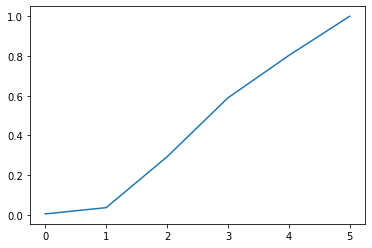

In [14]:
# график изменения условной вероятности P(status=5 | status=x) в зависимости от х
plt.plot(probability_5_status);

29% людей, которые просрочили платеж на 60-89 дней в дальнейшем просрочат его на 150 дней, в то время, как 3.6% людей, просрочивших платеж на срок до 60 дней просрочат его на 150 дней. Тогда к плохим клиентам предлагаю отнести клиентов, которые просрочили оплату кредитной карты на 60 и более дней.

In [15]:
balances_groupby = pd.DataFrame((grouped['STATUS'].max() >= 2).astype(int))
balances_groupby = balances_groupby.rename(columns={'STATUS': 'target'})
balances_groupby['open_month'] = - grouped['MONTHS_BALANCE'].min()  # сколько месяцев назад была открыта карта
balances_groupby.reset_index(inplace=True)

In [16]:
# оставляем только пересекающиеся записи в датасетах
set_idx_balances = set(balances_groupby['ID'])
set_idx_application = set(application['ID'])
cross_idx = set_idx_balances & set_idx_application
balances_groupby = balances_groupby[balances_groupby['ID'].isin(cross_idx)]
application = application[application['ID'].isin(cross_idx)]

Поскольку в данных есть временная составляющая, недопустимо, что бы мы не предсказывали из будующего в прошлое.
Что бы избежать такой ситуации, разобьем данные на тренировочный и тестовый датасеты следующим образом: 

тренировочный датасет - клиенты, открывшие карту 36-48 месяцев назад, а так же все плохие клиенты, открывшие карту позднее чем 24 месяца назад;

тестовый датасет - клиенты, открывшие карту 12-24 месяцев назад, а так же все плохие клиенты, открывшие карту менее 24 месяцев назад.

То есть для каждого набора мы выбираем окно в 2 года, рассматриваем всех клиентов, открывших карту втечении первого года, а так же плохих клиентов втечении всех двух лет (для тестового датасета - втечении всего, кроме тестовых данных). Второй год необходим для накопления информации о поведении клиента: допустим в конце первого года плохой клиент открыл карту, но ещё не успел просрочить платежи. При рассмотрении лишь одного года, мы будем считать, что данный клиент является хорошим, однако рассматривая окно в 2 года, мы увидим что он просрочил платеж во втором году и пометим его как плохого.

In [17]:
test = balances_groupby[((balances_groupby['open_month'] < 24) & (balances_groupby['open_month'] >= 12)) | ((balances_groupby['open_month'] < 24) & (balances_groupby['target'] == 1))]
train = balances_groupby[(balances_groupby['open_month'] >= 36) & (balances_groupby['open_month'] <= 48) | ((balances_groupby['open_month'] >= 24) & (balances_groupby['target'] == 1))]

In [18]:
train['target'].value_counts()

0    6665
1     428
Name: target, dtype: int64

In [19]:
test['target'].value_counts()

0    8670
1     188
Name: target, dtype: int64

In [20]:
train['target'].value_counts()[1] / train['target'].value_counts()[0]

0.06421605401350337

In [21]:
test['target'].value_counts()[1] / test['target'].value_counts()[0]

0.02168396770472895

Предобработаем признаки клиентов

In [22]:
def make_binarization(df, column, prefix, min_value=None, max_value=None, step=5):
    """
    бинаризуем непрерывные признаки
    """
    if min_value is None:
        min_value = int(df[column].min())
    if max_value is None:
        max_value = int(df[column].max())
    for i in range(min_value, max_value, step):
        df[f'{prefix}_{i}_{i + step}'] = df[column].apply(lambda x: True if x < i + step and x > i else False)
    return df


def make_one_hot_features(df, categorical_columns):
    """
    преобразуем категориальные признаки в one hot признаки
    """
    for col in categorical_columns:
        df = pd.concat([df, pd.get_dummies(df[col], prefix = f'one_hot_{col}')], axis = 1)
    one_hot_features = list(filter(lambda x: x[:7] == 'one_hot', df.columns))
    return df, one_hot_features

In [23]:
application['year'] = application['DAYS_BIRTH'].apply(lambda x: int(x / -365))
application.drop('DAYS_BIRTH', axis=1, inplace=True)

In [24]:
application = make_binarization(df=application, column='year', prefix='year')

In [25]:
application['years_employed'] = application['DAYS_EMPLOYED'].apply(lambda x: int(x / -365))
application.drop('DAYS_EMPLOYED', axis=1, inplace=True)

In [26]:
application = make_binarization(df=application, column='years_employed', prefix='years_employed', min_value=0)

In [27]:
categorical_features = []
continious_features = []
boolean_features = []
for col in application.columns.drop(['ID']):
    if application[col].dtype == 'O':
        categorical_features.append(col)
    elif application[col].dtype == 'bool':
        boolean_features.append(col)
    else:
        continious_features.append(col)
len(categorical_features), len(continious_features), len(boolean_features)

(8, 9, 19)

In [28]:
application, one_hot_features = make_one_hot_features(application, categorical_features)

In [29]:
columns_for_train = continious_features + boolean_features + one_hot_features

Разбиваем признаки на трейн и тест

In [30]:
train_idx = set(train['ID'])
test_idx = set(test['ID'])

In [31]:
train = pd.merge(application[application['ID'].isin(train_idx)], train, on="ID", how='inner')
test = pd.merge(application[application['ID'].isin(test_idx)], test, on="ID", how='inner')

Используем catboost из коробки

In [32]:
catboost = CatBoostClassifier(verbose=False, random_state=42)

In [33]:
catboost.fit(train[columns_for_train], train['target'])

Так как сильный дисбаланс классов, посмотрим на значение roc auc

In [34]:
roc_auc_score(train['target'], catboost.predict_proba(train[columns_for_train])[:, 1])

0.9720346558602267

In [35]:
roc_auc_score(test['target'], catboost.predict_proba(test[columns_for_train])[:, 1])

0.7509030896463718

75% пар (объект, скоринг) будут отранжированы правильно

Модель сильно переобучена, посмотрим на распределение важных признаков в трейновой и тестовой выборке

In [36]:
argsort = np.argsort(catboost.feature_importances_)[::-1]
dict(zip(np.array(columns_for_train)[argsort], np.sort(catboost.feature_importances_)[::-1]))  # важность признаков

{'AMT_INCOME_TOTAL': 15.202910037449358,
 'year': 9.86257162216385,
 'years_employed': 9.465095486596352,
 'CNT_FAM_MEMBERS': 3.486442854299251,
 'one_hot_FLAG_OWN_REALTY_Y': 3.0293421062473804,
 'years_employed_0_5': 2.9543639817320266,
 'CNT_CHILDREN': 2.9282362347213207,
 'FLAG_PHONE': 2.8415891029441642,
 'one_hot_OCCUPATION_TYPE_Laborers': 2.81370396773539,
 'one_hot_NAME_INCOME_TYPE_Commercial associate': 2.148968114588003,
 'one_hot_NAME_FAMILY_STATUS_Civil marriage': 2.106384061261369,
 'one_hot_NAME_EDUCATION_TYPE_Secondary / secondary special': 2.021790700995951,
 'one_hot_NAME_FAMILY_STATUS_Single / not married': 1.8346677870502606,
 'one_hot_FLAG_OWN_CAR_Y': 1.7202598978358394,
 'FLAG_WORK_PHONE': 1.7149241073825512,
 'one_hot_CODE_GENDER_M': 1.5918774205032722,
 'one_hot_OCCUPATION_TYPE_Core staff': 1.5263198954925532,
 'year_55_60': 1.5259869890437945,
 'year_35_40': 1.46392427708575,
 'one_hot_NAME_EDUCATION_TYPE_Higher education': 1.4134275261768892,
 'one_hot_CODE_GEND

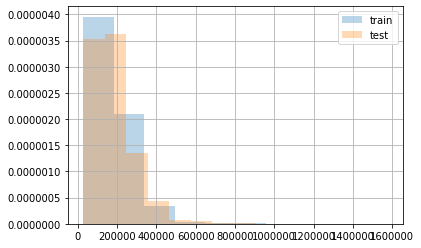

In [37]:
train['AMT_INCOME_TOTAL'].hist(alpha = 0.3, density=True, label='train')
test['AMT_INCOME_TOTAL'].hist(alpha = 0.3, density=True, label='test')
plt.legend();

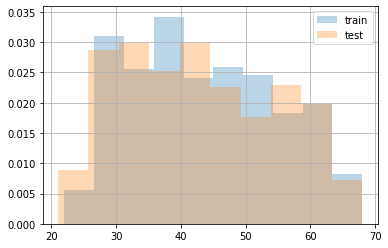

In [38]:
train['year'].hist(alpha = 0.3, density=True, label='train')
test['year'].hist(alpha = 0.3, density=True, label='test')
plt.legend();

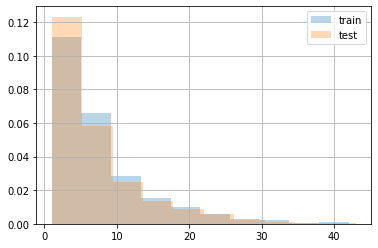

In [39]:
train[train['years_employed'] > 0]['years_employed'].hist(alpha = 0.3, density=True, label='train')
test[test['years_employed'] > 0]['years_employed'].hist(alpha = 0.3, density=True, label='test')
plt.legend()

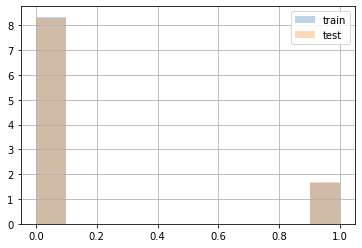

In [40]:
train['one_hot_OCCUPATION_TYPE_Laborers'].hist(alpha = 0.3, density=True, label='train')
test['one_hot_OCCUPATION_TYPE_Laborers'].hist(alpha = 0.3, density=True, label='test')
plt.legend()

Распределение признаков в трейне и тесте не сильно отличаются, но качество на трейне значительно выше, чем качество на тестовых данных. Посмотрим, на сколько сильно отличаются объекты в тренировочном и тестовом датасетах

In [41]:
catboost = CatBoostClassifier(verbose=False, random_state=42)

In [42]:
train['train'] = 1
test['train'] = 0

In [43]:
df = pd.concat([train, test], axis=0)

In [44]:
df['train'].value_counts()

0    8858
1    7093
Name: train, dtype: int64

In [45]:
catboost.fit(df[columns_for_train], df['train'])

In [46]:
accuracy_score(df['train'], catboost.predict(df[columns_for_train])) 

0.7001441915867344

В 70% случаях, модель может разделить трейн и тест, значит совместное распределение признаков достаточно сильно различается.

В таком случае есть можно попробовать сделать две вещи: 

1 - аналогичным образом создать валидационный датасет и при помощи random search или grid search регуляризировать бустинг, при этом изменяя параметры depth, l2_leaf_reg, iterations, learning_rate, min_data_in_leaf. Для валидации используем новый созданный датасет (на кросс-валидации скорее всего качество будет завышенное, т.к. данные в различных времянных окнах отличаются) и стараемся максимизировать на нем качество

2 - изменять тренировочный и тестовый корпуса. Окно величиной два года - скорее всего слишком велико, имеет смысл рассмотреть окно меньшего размера, так же включение в тренировочный набор более старых данных может добавить обобщающей способности модели

После получения моделью удовлетворительного качества (наверное инференс модели нужно откалибровать на вероятность, если от вероятности того, что клиент является плохим зависит сумма, на которую выдается кридитная карта), можно валидировать модель на реальных данных. Делать это можно при помощи а/б теста. Разбить потенциальных клиентов на две группы, определить измеряемую величину (число плохих клиентов/деньги), определить какое изменение ключевой метрики мы ожидаем получить, определиться с мощностью и уровнем значимости, а затем определить определить количество клиентов в каждой из подгрупп. На протяжении некоторого времени (зависит от количества клиентов в группах) выдавать кредитные карты согласно предсказаниям моделей из группы а (если сейчас используется модель) и группы б (разрабатываемая модель). После того, как необходимое число клиентов будет набрано в каждоый группе, тест необходимо остановить и подождать некоторое время, по истичению которого можно измерять ключевую метрику. Проверить гипотезу о том, что имеется статистическая значимость между измеряемыми величинами в обеих группах.